# Circuit solver using II Kirchoff Law and Gauss-Jordan pivoted matrix solve
## Aleksander Mikucki

few imports, a fix for pint's unit display and a function for plotting edge labels

In [171]:
import networkx as nx
import matplotlib.pyplot as plt
import pint
import numpy as np
unit = pint.UnitRegistry()

In [172]:
class Quantity(unit.Quantity):
    def __repr__(self):
        return str(self)
unit.Quantity = Quantity

In [202]:
def drawG(graph):
    pos=nx.spring_layout(graph)
    nx.draw(graph,pos, with_labels=True)
    nx.draw_networkx_edge_labels(graph,pos)

We assume a convention where a positive sign of current or SEM means that it flows from a smaller index veritce to a highier index one.

In [203]:
def setSignFromVerticeOrder(vFrom, vTo, val):
    if(vFrom < vTo): return val
    else: return -val

Here we provide a circuit description, here are a few sample ones

In [204]:
circuit1 = nx.Graph()
circuit1.add_node(1)
circuit1.add_node(2)
circuit1.add_node(3)
circuit1.add_node(4)
circuit1.add_edges_from([
    (1, 2, {'R': 3 * unit.ohm, 'SEM':-1*unit.volt}), 
    (2,3,{'SEM':1 * unit.volt,'R':1*unit.ohm}),
    (3,1),
    (2,4,{'R':1*unit.ohm}),
    (3,4,{'R':3*unit.ohm})
])

In [205]:
circuit2 = nx.Graph()
circuit2.add_node(1)
circuit2.add_node(2)
circuit2.add_node(3)
circuit2.add_node(4)

circuit2.add_edges_from([
    (1, 2, {'SEM':1*unit.volt}), 
    (2,3,{'SEM':1*unit.volt}),
    (3,1,{'R':1*unit.ohm}),
    (2,4,{'R':3*unit.ohm}),
    (4,1),
    (3,4,{'R':1*unit.ohm})
])

In [206]:
circuit3 = nx.Graph()
circuit3.add_node(1)
circuit3.add_node(2)
circuit3.add_node(3)
circuit3.add_node(4)

circuit3.add_edges_from([
    (1, 2, {'SEM':1*unit.volt}), 
    (2,3,{'SEM':1*unit.volt}),
    (3,1,{'R':1*unit.ohm}),
    (2,4,{'R':3*unit.ohm}),
    (2,1,{'R':3*unit.ohm}),
    (4,1)
])

In [207]:
# this is a singular one
circuit4 = nx.Graph()
circuit4.add_node(1)
circuit4.add_node(2)
circuit4.add_node(3)
circuit4.add_edges_from([
    (1, 2, {'SEM':1*unit.volt}), 
    (2,3,{'SEM':1*unit.volt}),
    (3,1)
])

In [208]:
circuit5 = nx.Graph()
circuit5.add_node(1)
circuit5.add_node(2)
circuit5.add_node(3)
circuit5.add_node(4)
circuit5.add_node(5)
circuit5.add_node(6)
circuit5.add_node(7)
circuit5.add_edges_from([
    (1, 2, {'R': 3 * unit.ohm, 'SEM':-1*unit.volt}), 
    (5, 2, {'R': 10 * unit.ohm, 'SEM':2*unit.volt}), 
    (7, 1, {'R': 3 * unit.ohm, 'SEM':-1*unit.volt}), 
    (2,3,{'SEM':1 * unit.volt,'R':1*unit.ohm}),
    (3,1,{'R':1*unit.ohm}),
    (2,3,{'R':1*unit.ohm}),
    (7,2,{'R':1*unit.ohm}),
    (6,1,{'R':1*unit.ohm}),
    (6,3,{'R':1*unit.ohm}),
    (2,4,{'R':1*unit.ohm}),
    (3,4,{'R':3*unit.ohm}),
    (5,1)
])

In [209]:
circuit = circuit1

We assume that SEM is positive if it has a minus at a node with a lower index

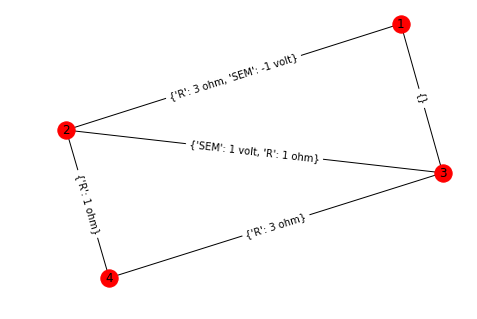

In [210]:
drawG(circuit)

We use a library function for getting all basic cycles in a graph

In [211]:
cycleVerticeIndexes = nx.cycle_basis(circuit)

In [212]:
cycleVerticeIndexes

[[2, 3, 1], [2, 4, 3]]

We convert them into edge descriptions

In [213]:
cycleEdgeIndexes = []
for cycle in cycleVerticeIndexes:
    edges = []
    for i,v in enumerate(cycle):
        edges.append([v, cycle[(i+1) % len(cycle)]])
    cycleEdgeIndexes.append(edges)
cycleEdgeIndexes

[[[2, 3], [3, 1], [1, 2]], [[2, 4], [4, 3], [3, 2]]]

Now we need to start mapping it into a matrix for solving it numerically
http://fourier.eng.hmc.edu/e84/lectures/ch2/node2.html

We'll assign a loop current to each cycle and put these currents into our graph

In [214]:
for idx,cycle in enumerate(cycleEdgeIndexes):
    for edge in cycle:
        nx.set_edge_attributes(circuit, 
                               name = 'LI', 
                               values = {
                                   (edge[0],edge[1]):
                                   {**circuit[edge[0]][edge[1]].get('LI',{}),
                                   **{('i' + str(idx)):setSignFromVerticeOrder(edge[0],edge[1],1)}}
                                        })

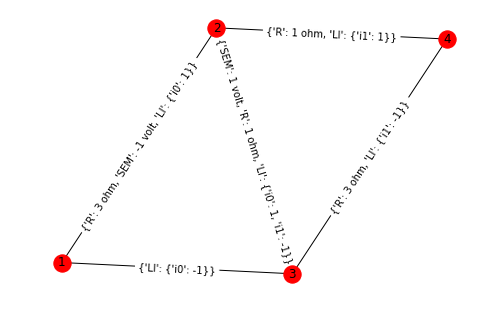

In [215]:
drawG(circuit)

In [216]:
cycleEdges = []
for cycle in cycleEdgeIndexes:
    cycleEdges.append(list(map(lambda e:(e[0],e[1], circuit[e[0]][e[1]]),cycle)))
cycleEdges

[[(2, 3, {'SEM': 1 volt, 'R': 1 ohm, 'LI': {'i0': 1, 'i1': -1}}),
  (3, 1, {'LI': {'i0': -1}}),
  (1, 2, {'R': 3 ohm, 'SEM': -1 volt, 'LI': {'i0': 1}})],
 [(2, 4, {'R': 1 ohm, 'LI': {'i1': 1}}),
  (4, 3, {'R': 3 ohm, 'LI': {'i1': -1}}),
  (3, 2, {'SEM': 1 volt, 'R': 1 ohm, 'LI': {'i0': 1, 'i1': -1}})]]

We compose Kirhoff II law for each loop, summing SEM and R for each loop current (i0, i1, etc.)

In [217]:
SEMArray = []
IArray = []
for idx, loop in enumerate(cycleEdges):
    sumOfSEM = 0
    sumOfResistancesPerCurrent = {}
    for edge in loop:
        edgeCurrents = edge[2].get('LI',{})
        edgeResistance = edge[2].get('R',0 * unit.ohm)
        sumOfSEM += edgeCurrents.get('i'+str(idx),0) * edge[2].get('SEM',0 * unit.volt).magnitude
        for current in edgeCurrents.keys():
            sumOfResistancesPerCurrent[current] = sumOfResistancesPerCurrent.get(current,0*unit.ohm) + edgeResistance
    SEMArray.append(sumOfSEM)
    IArray.append(list(map(lambda idx: sumOfResistancesPerCurrent.get('i'+str(idx),0*unit.ohm).magnitude, range(0,len(cycleEdges)))))

In [218]:
SEMArray

[0, -1]

In [219]:
IArray

[[4, 1], [1, 5]]

Let's see what we should expect from our gauss_jordan implementation

In [220]:
a = np.asarray(IArray)
b = np.asarray(SEMArray)
print(np.linalg.solve(a,b))

[ 0.05263158 -0.21052632]


In [221]:
def gauss_jordan(m, eps=1.0 / 10 ** 10):
    (height, width) = m.shape
    for y in range(0, height):
        # we swap the rows around (pivoting) as to minimize numeric error
        indexOfMaxPivotRow = y
        for currIndex in range(y + 1, height):
            if abs(m[currIndex][y]) > abs(m[indexOfMaxPivotRow][y]):
                indexOfMaxPivotRow = currIndex
        m[y], m[indexOfMaxPivotRow] = m[indexOfMaxPivotRow], m[y]
        # We check for matrix simmilarity, 
        # which signifies that there are no resistance values set
        # The circuit is a short circuit
        if abs(m[y][y]) <= 1e-9:
            return False
        for currIndex in range(y + 1, height):
            multiplier = m[currIndex][y] / m[y][y]
            for x in range(y, width):
                m[currIndex][x] -= m[y][x] * multiplier
    for y in range(height - 1, 0 - 1, -1):
        multiplier = m[y][y]
        for currIndex in range(0, y):
            for x in range(width - 1, y - 1, -1):
                m[currIndex][x] -= m[y][x] * m[currIndex][y] / multiplier
        m[y][y] /= multiplier
        for x in range(height, width):
            m[y][x] /= multiplier
    return True

In [222]:
b = b.reshape(-1,1)

In [223]:
m = np.array(np.column_stack([a,b]),dtype=float)

In [224]:
m

array([[ 4.,  1.,  0.],
       [ 1.,  5., -1.]])

In [225]:
gauss_jordan(m)

True

In [226]:
m

array([[ 1.        ,  0.        ,  0.05263158],
       [ 0.        ,  1.        , -0.21052632]])

Now we just need to fill this data back into our graph

In [227]:
currents = {}
for idx, row in enumerate(m):
    currents['i'+str(idx)] = row[-1]
currents

{'i0': 0.05263157894736842, 'i1': -0.21052631578947367}

In [228]:
for idx,cycle in enumerate(cycleEdgeIndexes):
    for edge in cycle:
        nx.set_edge_attributes(circuit, 
                               name = 'I', 
                               values = {
                                   (edge[0],edge[1]):
                                   round(sum(list(map(lambda ilElem: currents[ilElem[0]]*ilElem[1]*setSignFromVerticeOrder(edge[0],edge[1],1),circuit[edge[0]][edge[1]].get('LI',{}).items()))),2),
                                        })
nx.set_edge_attributes(circuit, 
                       name = 'LI', 
                       values = [])

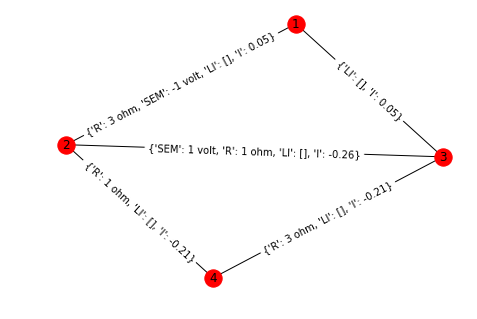

In [229]:
drawG(circuit)